# Follow-up: Animated population plots
Natalia Vélez, June 2020

The goal of this notebook is to give a birds-eye view of the growth of communities by plotting births and deaths over time.

In [56]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches

sns.set_context('paper')

Load data:

In [57]:
migration_data = pd.read_csv('outputs/migration_201907.tsv', sep='\t', index_col = None)
migration_data.head()

,release,uniqueID,timestamp,birth,death,age,cause_of_death,birthX,birthY,deathX,deathY,distance
0,251,1842398_bigserver2_251,1564444832,[-325 209],[-334 219],5.75,hunger,-325,209,-334,219,13.453624
1,251,1842399_bigserver2_251,1564444836,[ 67 -266],[ 44 -292],0.53,hunger,67,-266,44,-292,34.713110
2,251,1842400_bigserver2_251,1564444863,[ 16 -57],[ 16 -57],0.09,disconnect,16,-57,16,-57,0.000000
3,251,1842401_bigserver2_251,1564444864,[146 49],[156 103],0.48,hunger,146,49,156,103,54.918121
4,251,1842402_bigserver2_251,1564444866,[68 64],[68 64],0.54,hunger,68,64,68,64,0.000000


# "Popcorn" plot

### Select a subset of the data

Units of analysis: Plot data separately by release

In [58]:
releases = np.unique(migration_data['release'])
print('Releases: %s' % releases)

migration_data.groupby('release')['uniqueID'].count()

Releases: [251 256 260 262 266 268 270 272 276 278 280 283 286 288 290 292 294 296
 297 298 300]


release
251     20533
256    118383
260     55892
262     56366
266     20498
268     28298
270     23578
272     19836
276     19501
278     24271
280     23117
283     11119
286     29674
288     13668
290     38186
292     27153
294      3151
296     17745
297      8523
298     71512
300     30374
Name: uniqueID, dtype: int64

Choose a release to test out this visualization, and subset the data:

In [59]:
r = 300

migration_sub = migration_data[migration_data['release'] == r].reset_index(drop=True)
migration_sub = migration_sub.sort_values(by='timestamp')

### Prepare data for plotting

Mark start and end times for each point:

In [60]:
migration_sub = migration_data[migration_data['release'] == r].reset_index(drop=True)
migration_sub = migration_sub.sort_values(by='timestamp')

# Calculate start and end times
migration_sub['t_start'] = migration_sub['timestamp'] - migration_sub['timestamp'][0]
migration_sub['t_end'] = migration_sub['t_start'] + migration_sub['age']*60

# Convert to integer
migration_sub['t_start'] = migration_sub['t_start'].astype(np.int)
migration_sub['t_end'] = migration_sub['t_end'].astype(np.int)
migration_sub.head()

,release,uniqueID,timestamp,birth,death,age,cause_of_death,birthX,birthY,deathX,deathY,distance,t_start,t_end
0,300,2513163_bigserver2_300,1578009616,[-61761 -200],[-61761 -200],0.06,disconnect,-61761,-200,-61761,-200,0.000000,0,3
1,300,2513164_bigserver2_300,1578009624,[-81532 -20077],[-81534 -20074],15.22,hunger,-81532,-20077,-81534,-20074,3.605551,8,921
2,300,2513165_bigserver2_300,1578009625,[-60314 -462],[-60314 -462],0.03,disconnect,-60314,-462,-60314,-462,0.000000,9,10
3,300,2513166_bigserver2_300,1578009626,[-81548 -20044],[-81534 -20068],15.33,hunger,-81548,-20044,-81534,-20068,27.784888,10,929
4,300,2513167_bigserver2_300,1578009636,[-57759 -314],[-57759 -314],0.11,disconnect,-57759,-314,-57759,-314,0.000000,20,26


How long is the period studied?

In seconds:

In [61]:
t_in_secs = migration_sub[['t_start',  't_end']].max()
total_t = t_in_secs['t_end']
print(t_in_secs)

t_start    518335
t_end      518566
dtype: int64


In days:

In [62]:
t_in_days = t_in_secs/60/60/24
print(t_in_days)

t_start    5.999248
t_end      6.001921
dtype: float64


### Choose spatial and temporal window to plot

**Spatial:** Get range of x- and y-values. We want to keep the bounds of the plot consistent through the animation.

In [63]:
xs = migration_sub.birthX.values
x_bounds = (np.min(xs)-1000, np.max(xs)+1000)

ys = migration_sub.birthY.values
y_bounds = (np.min(ys)-1000, np.max(ys)+1000)

print(x_bounds)
print(y_bounds)

(-84031, 5073)
(-21849, 50712)


**Temporal:** Set intervals for animation. All told, we want the animation to last 30 seconds.

In [64]:
fps = 30
total_time_msec = 30*1000
interval = 10
n_frames = int(total_time_msec/interval)
span_per_frame = total_t/n_frames/60

t_frames = np.linspace(0, total_t, n_frames)

print('Generating %i frames' % n_frames)
print('Each frame spans %0.2f minutes' % span_per_frame)
print(t_frames)

Generating 3000 frames
Each frame spans 2.88 minutes
[0.00000000e+00 1.72912971e+02 3.45825942e+02 ... 5.18220174e+05
 5.18393087e+05 5.18566000e+05]


### Generate plot

Each dot shows the location where a player was born; the dot appears when the player was born and disappears when the player days. Moving forward, we can build on this visualization by:

* Tracing where each player died
* Color-coding players by lineage/spatial cluster

...But that's too many moving parts for now!

Static plot:

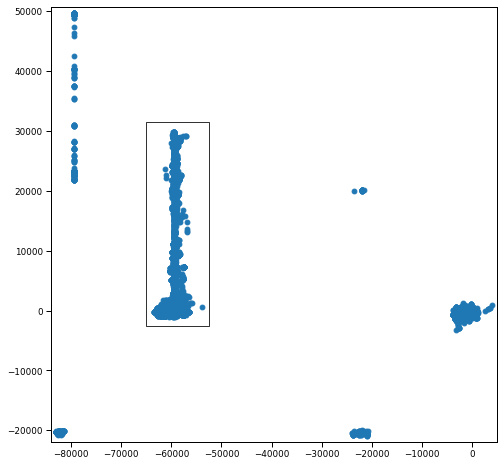

In [71]:
x = migration_sub['birthX']
y = migration_sub['birthY']

fig, ax = plt.subplots(figsize=(8,8))
plt.xlim(*x_bounds)
plt.ylim(*y_bounds)

# Draw rectangle around central cluster
center_bottom = (-65000, -2500)
center_w = 12500
center_h = 34000

center_xlim = (center_bottom[0], center_bottom[0]+center_w)
center_ylim = (center_bottom[1], center_bottom[1]+center_h)

rect = plt.Rectangle(center_bottom, center_w, center_h, fill = False)
ax.add_patch(rect)

# Plot data
graph, = plt.plot(x, y, 'o') # debug: static plot



Animated plot:

Saving animation to: plots/animated_population_release-300.mpeg


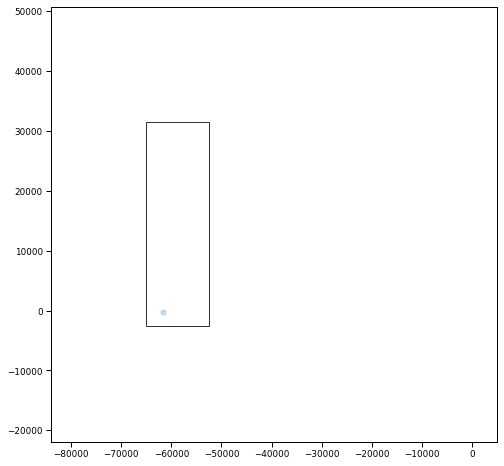

In [72]:
x = migration_sub['birthX']
y = migration_sub['birthY']

fig, ax = plt.subplots(figsize=(8,8))
plt.xlim(*x_bounds)
plt.ylim(*y_bounds)

# Draw rectangle around central cluster
center_xlim = (center_bottom[0], center_bottom[0]+center_w)
center_ylim = (center_bottom[1], center_bottom[1]+center_h)

rect = plt.Rectangle(center_bottom, center_w, center_h, fill = False)
ax.add_patch(rect)

graph, = plt.plot([], [], 'o', alpha = 0.25)

def animate(t):
    
    include = (migration_sub['t_start'] <= t) & (migration_sub['t_end'] > t)
    graph.set_data(x[include], y[include])
    return graph

ani = animation.FuncAnimation(fig, animate, frames=t_frames, interval=interval)

# Save animation to video
out_file = 'plots/animated_population_release-%i.mpeg' % r
print('Saving animation to: %s' % out_file)

ani.save(out_file)

Plot central cluster only:

Saving animation to: plots/animated_population_release-300_center.mpeg


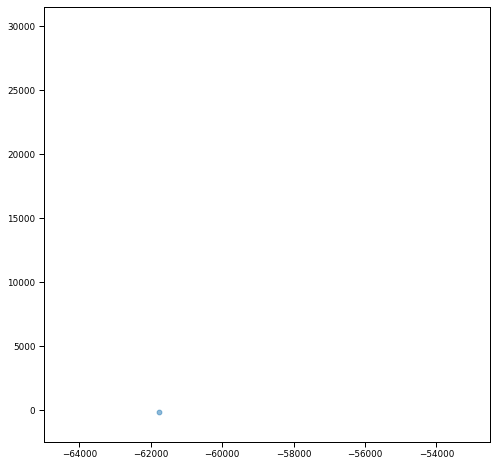

In [73]:
fig = plt.figure(figsize=(8, 8))
plt.xlim(center_xlim)
plt.ylim(center_ylim)
graph, = plt.plot([], [], 'o', alpha = 0.5)

def animate(t):
    
    include = (migration_sub['t_start'] <= t) & (migration_sub['t_end'] > t)
    graph.set_data(x[include], y[include])
    return graph

ani = animation.FuncAnimation(fig, animate, frames=t_frames, interval=interval)

# Save animation to video
out_file = 'plots/animated_population_release-%i_center.mpeg' % r
print('Saving animation to: %s' % out_file)

ani.save(out_file)